In [6]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

import helper

# Load rMATS outputs

In [16]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]


In [8]:
rpl22_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_oe.h5",key="rmats")
rpl22l1_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_oe.h5",key="rmats")
rpl22l1_kd1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd1.h5",key="rmats")
rpl22l1_kd2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd2.h5",key="rmats")
rpl22_a_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko1.h5",key="rmats")
rpl22_a_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko2.h5",key="rmats")
rpl22_b_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko1.h5",key="rmats")
rpl22_b_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko2.h5",key="rmats")

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd1_rmats = rpl22l1_kd1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd2_rmats = rpl22l1_kd2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko1_rmats = rpl22_a_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko2_rmats = rpl22_a_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko1_rmats = rpl22_b_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko2_rmats = rpl22_b_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

# Differential splicing

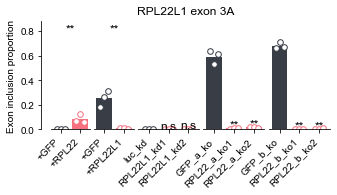

In [9]:
axes = helper.all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")
plt.suptitle("RPL22L1 exon 3A")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf",bbox_inches="tight",background="transparent")

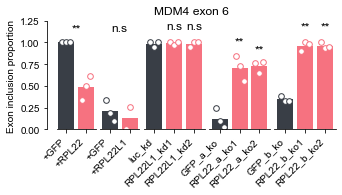

In [10]:
axes = helper.all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

plt.suptitle("MDM4 exon 6")
plt.savefig("../plots/MDM4_6_splicing.pdf",bbox_inches="tight",background="transparent")

# Splicing types

In [14]:
def plot_splice_types(rmats_diffs, qval_cutoff=0.01, ax=None,legend=False):
    
    if ax is None:
        ax = plt.subplot(111)

    significants = rmats_diffs.copy(
        deep=True)[rmats_diffs["qval"] < qval_cutoff]

    significants["treatment_increase"] = significants["treatment_median"] > significants["control_median"]

    significants["treatment_increase"] = significants["treatment_increase"].replace({True: "Inclusion",
                                                                                     False: "Exclusion"})

    significants = significants.groupby(
        "splice_type")["treatment_increase"].value_counts()
    significants = significants.unstack()

    significants, _ = significants.align(
        pd.Series(index=splice_types), join="right", axis=0)
    significants = significants.fillna(0)

    significants["splice_type"] = significants.index
    
    significants.columns.name = ""
    
    significants.plot(x="splice_type",
                      y=["Exclusion", "Inclusion"],
                      kind="bar",
                      cmap=mpl.colors.ListedColormap(
                          ["#dbe2ef", "#3f72af"]),
                      ax=ax,
                      stacked=True,
                      width=0.5,
                      legend=legend
                      )
    
    plt.ylabel("Frequency")
    plt.xlabel("Splice type")
    
    plt.xticks(rotation=45,ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('axes', -0.05))

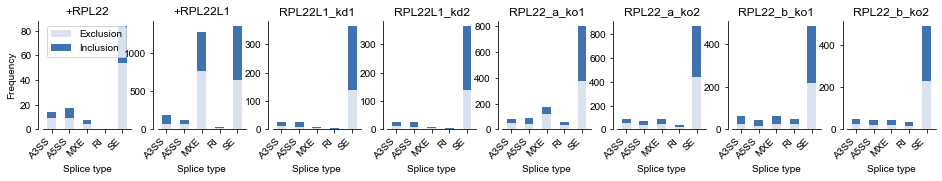

In [17]:
plt.figure(figsize=(16,2))
    
for experiment_idx, experiment in enumerate([rpl22_oe_rmats,
                                             rpl22l1_oe_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22_a_ko1_rmats,
                                             rpl22_a_ko2_rmats,
                                             rpl22_b_ko1_rmats,
                                             rpl22_b_ko2_rmats
                                            ]):

    ax = plt.subplot(1,8,experiment_idx+1)
    plot_splice_types(experiment,ax=ax,legend=experiment_idx<1)
    
    if experiment_idx > 0:
        plt.ylabel("")
        
    ax.set_title(display_names[experiment_idx])
        
plt.subplots_adjust(wspace=0.3)

plt.savefig("../plots/significant_splice_types.pdf",bbox_inches="tight",background="transparent")